In [1]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    # Check if rows are empty
    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Determine which format should be used
    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows: 
        if row[7] == eventname:  # Check event column
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if len(timestamps) == 0:
        print(f"No {eventname} events found in file: {filename}")
        return []

    t0 = rows[0][0]
    day = t0.split()[0] 
    lightson = day + " 07:00:00"
    refpoint = datetime.strptime(lightson, date_format)
    
    pellettimes = []
    for t in timestamps:
        Deltat = t - refpoint
        Deltatinseconds = Deltat.total_seconds()
        Deltatinhours = Deltatinseconds / 3600
        pellettimes.append(Deltatinhours)

    return pellettimes


# Function to get meal, snack, and mega meal metrics, including mega_meal_frequency and mega_meal_size
def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, 0, 0, [[0]*24]*7, [[0]*24]*7, [[0]*24]*7, 0, 0, 0, 0)

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    mega_meals = []
    current_event = [pellettimes[0]]

    # Hourly tracking for each day
    hourly_meals_per_day = [[0]*24 for _ in range(7)]
    hourly_snacks_per_day = [[0]*24 for _ in range(7)]
    hourly_mega_meals_per_day = [[0]*24 for _ in range(7)]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) == 1:
                snacks.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:  # Make sure we are within the 7-day boundary
                    hourly_snacks_per_day[day_index][hour] += 1
            elif 2 <= len(current_event) <= 4:
                meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_meals_per_day[day_index][hour] += 1
            elif len(current_event) >= 5:
                mega_meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_mega_meals_per_day[day_index][hour] += 1
            current_event = [pellettimes[i + 1]]

    # Handle the last sequence
    if current_event:
        day_index = int(current_event[0] // 24)
        hour = int(current_event[0]) % 24
        if len(current_event) == 1:
            snacks.append(current_event)
            if day_index < 7:
                hourly_snacks_per_day[day_index][hour] += 1
        elif 2 <= len(current_event) <= 4:
            meals.append(current_event)
            if day_index < 7:
                hourly_meals_per_day[day_index][hour] += 1
        elif len(current_event) >= 5:
            mega_meals.append(current_event)
            if day_index < 7:
                hourly_mega_meals_per_day[day_index][hour] += 1

    nmeals = len(meals)
    nsnacks = len(snacks)
    n_mega_meals = len(mega_meals)  # Add the number of mega meals

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0
    mega_meal_frequency = n_mega_meals / total_observation_period if total_observation_period > 0 else 0
    average_mega_meal_size = sum(len(meal) for meal in mega_meals) / n_mega_meals if n_mega_meals else 0

    return (mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, 
            mega_meal_frequency, average_mega_meal_size, hourly_meals_per_day, 
            hourly_snacks_per_day, hourly_mega_meals_per_day, meals, snacks, mega_meals, n_mega_meals)


# Function to get events (meals, snacks, mega meals) per day based on timestamps
def get_events_per_day(events, days=7):
    events_per_day = [0] * days  # Initialize with zeros for the duration of the phase
    for event_list in events:
        if len(event_list) > 0:
            event_day = int(event_list[0] // 24)
            if event_day < days:
                events_per_day[event_day] += 1
    return events_per_day

# Function to calculate pellets per day
def get_pellets_per_day(timestamps, days=7):
    pellets_per_day = [0] * days
    for day in range(days):
        pellets = [t for t in timestamps if (t > day * 24) and (t < (day + 1) * 24)]
        n_pellets = len(pellets)
        pellets_per_day[day] = n_pellets

    return pellets_per_day


# Function to calculate inter-pellet intervals (IPI)
def get_interpellet_intervals(pellettimes):
    IPIs = np.diff(pellettimes)
    return IPIs

# Function to calculate intermeal intervals (IMI)
def get_intermeal_interval(pellettimes, meal_threshold=1/60):
    IPIs = np.diff(pellettimes)
    IMIs = [x for x in IPIs if x > meal_threshold]
    average_IMI = np.mean(IMIs) if IMIs else 0  # Handle case with no IMIs
    return average_IMI

# Load the metafile and process the data
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, "Pellet")
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Add meal, snack, mega meal metrics, and IMI, IPI calculations to the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])

    # Get metrics for GRAIN, PR, and NR phases
    grain_metrics = get_meal_and_snack_metrics(grain_timestamps)
    pr_metrics = get_meal_and_snack_metrics(pr_timestamps)
    nr_metrics = get_meal_and_snack_metrics(nr_timestamps)

    # GRAIN phase
    (
        mice[key]["grain_meal_size"],
        mice[key]["grain_snack_size"],
        mice[key]["grain_number_of_meals"],
        mice[key]["grain_meal_frequency"],
        mice[key]["grain_number_of_snacks"],
        mice[key]["grain_snack_frequency"],
        mice[key]["grain_mega_meal_frequency"],
        mice[key]["grain_mega_meal_size"],
        mice[key]["grain_hourly_meals"],
        mice[key]["grain_hourly_snacks"],
        mice[key]["grain_hourly_mega_meals"],
        grain_meals,
        grain_snacks,
        grain_mega_meals,
        mice[key]["grain_number_of_mega_meals"]  # Store the number of mega meals
    ) = grain_metrics

    # PR phase
    (
        mice[key]["pr_meal_size"],
        mice[key]["pr_snack_size"],
        mice[key]["pr_number_of_meals"],
        mice[key]["pr_meal_frequency"],
        mice[key]["pr_number_of_snacks"],
        mice[key]["pr_snack_frequency"],
        mice[key]["pr_mega_meal_frequency"],
        mice[key]["pr_mega_meal_size"],
        mice[key]["pr_hourly_meals"],
        mice[key]["pr_hourly_snacks"],
        mice[key]["pr_hourly_mega_meals"],
        pr_meals,
        pr_snacks,
        pr_mega_meals,
        mice[key]["pr_number_of_mega_meals"]  # Store the number of mega meals
    ) = pr_metrics

    # NR phase
    (
        mice[key]["nr_meal_size"],
        mice[key]["nr_snack_size"],
        mice[key]["nr_number_of_meals"],
        mice[key]["nr_meal_frequency"],
        mice[key]["nr_number_of_snacks"],
        mice[key]["nr_snack_frequency"],
        mice[key]["nr_mega_meal_frequency"],
        mice[key]["nr_mega_meal_size"],
        mice[key]["nr_hourly_meals"],
        mice[key]["nr_hourly_snacks"],
        mice[key]["nr_hourly_mega_meals"],
        nr_meals,
        nr_snacks,
        nr_mega_meals,
        mice[key]["nr_number_of_mega_meals"]  # Store the number of mega meals
    ) = nr_metrics

    # Events per day and pellets per day (as previously done)
    mice[key]["grain_meals_per_day"] = get_events_per_day(grain_meals, days=3)
    mice[key]["pr_meals_per_day"] = get_events_per_day(pr_meals, days=7)
    mice[key]["nr_meals_per_day"] = get_events_per_day(nr_meals, days=7)

    mice[key]["grain_snacks_per_day"] = get_events_per_day(grain_snacks, days=3)
    mice[key]["pr_snacks_per_day"] = get_events_per_day(pr_snacks, days=7)
    mice[key]["nr_snacks_per_day"] = get_events_per_day(nr_snacks, days=7)

    mice[key]["grain_mega_meals_per_day"] = get_events_per_day(grain_mega_meals, days=3)
    mice[key]["pr_mega_meals_per_day"] = get_events_per_day(pr_mega_meals, days=7)
    mice[key]["nr_mega_meals_per_day"] = get_events_per_day(nr_mega_meals, days=7)

    mice[key]["grain_pellets_per_day"] = get_pellets_per_day(mice[key]["grain_timestamps"], days=3)
    mice[key]["pr_pellets_per_day"] = get_pellets_per_day(mice[key]["pr_timestamps"], days=7)
    mice[key]["nr_pellets_per_day"] = get_pellets_per_day(mice[key]["nr_timestamps"], days=7)


# Now combine events and pellets per day for the entire 17-day time course (as before)
for key in mice.keys():
    # Combine pellets per day
    mice[key]["all_pellets_per_day"] = (
        mice[key].get("grain_pellets_per_day", [0] * 3) +
        mice[key].get("pr_pellets_per_day", [0] * 7) +
        mice[key].get("nr_pellets_per_day", [0] * 7)
    )

    # Combine meals per day
    mice[key]["all_meals_per_day"] = (
        mice[key].get("grain_meals_per_day", [0] * 3) +
        mice[key].get("pr_meals_per_day", [0] * 7) +
        mice[key].get("nr_meals_per_day", [0] * 7)
    )

    # Combine snacks per day
    mice[key]["all_snacks_per_day"] = (
        mice[key].get("grain_snacks_per_day", [0] * 3) +
        mice[key].get("pr_snacks_per_day", [0] * 7) +
        mice[key].get("nr_snacks_per_day", [0] * 7)
    )

    # Combine mega meals per day
    mice[key]["all_mega_meals_per_day"] = (
        mice[key].get("grain_mega_meals_per_day", [0] * 3) +
        mice[key].get("pr_mega_meals_per_day", [0] * 7) +
        mice[key].get("nr_mega_meals_per_day", [0] * 7)
    )

# Output the results to check the data structure
for key, value in mice.items():
    print(f"Mouse {key}:")
    print("  Pellets per day:", mice[key]["all_pellets_per_day"])
    print("  Meals per day:", mice[key]["all_meals_per_day"])
    print("  Snacks per day:", mice[key]["all_snacks_per_day"])
    print("  Mega Meals per hour:", mice[key]["nr_hourly_mega_meals"])
    print("  Mega Meals Frequency:", mice[key]["nr_mega_meal_frequency"])
    print("  Mega Meals Size:", mice[key]["nr_mega_meal_size"])


Mouse FEDXA01:
  Pellets per day: [340, 271, 224, 161, 155, 176, 184, 215, 231, 240, 246, 234, 222, 211, 241, 223, 219]
  Meals per day: [43, 25, 23, 35, 28, 31, 24, 24, 31, 14, 9, 18, 18, 15, 13, 9, 6]
  Snacks per day: [30, 18, 25, 32, 44, 52, 62, 28, 25, 13, 13, 14, 14, 19, 18, 12, 13]
  Mega Meals per hour: [[0, 0, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 3, 3, 1, 2, 0, 1, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 3, 3, 2, 1, 2, 0, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 0, 0, 3], [0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 4, 2, 3, 2, 0, 1, 0, 1, 1], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 2]]
  Mega Meals Frequency: 1.0133227626203154
  Mega Meals Size: 7.27810650887574
Mouse FEDXA02:
  Pellets per day: [304, 214, 194, 154, 153, 204, 211, 203, 226, 214, 225,

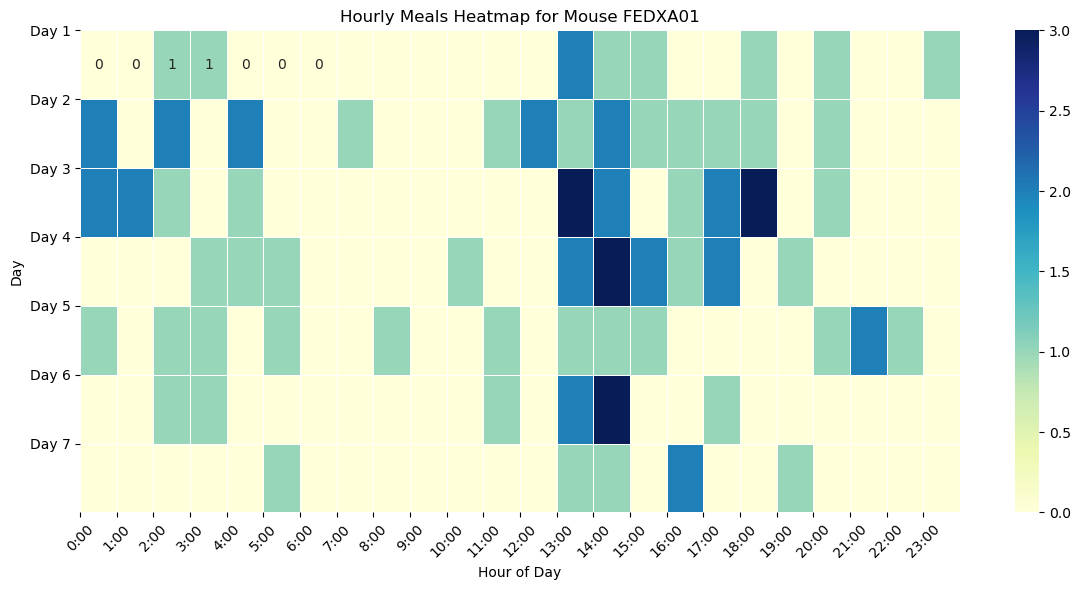

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `mice` is the dictionary containing all the data as in your code
# Here, I'll use the 'nr_hourly_meals' data for each mouse

# Example for a specific mouse key (you can loop through all the keys if needed)
mouse_key = list(mice.keys())[0]  # Select the first mouse key for visualization, adjust as needed
hourly_meals_per_day = mice[mouse_key]["nr_hourly_meals"]  # Retrieve the hourly meal data

# Convert to numpy array for easier manipulation
hourly_meals_per_day = np.array(hourly_meals_per_day)

# Create a heatmap using seaborn
plt.figure(figsize=(12, 6))
sns.heatmap(hourly_meals_per_day, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5)

# Set labels
plt.title(f"Hourly Meals Heatmap for Mouse {mouse_key}")
plt.xlabel("Hour of Day")
plt.ylabel("Day")

# Customize tick labels to show hours and days more clearly
plt.xticks(ticks=np.arange(24), labels=[f"{i}:00" for i in range(24)], rotation=45)
plt.yticks(ticks=np.arange(7), labels=[f"Day {i+1}" for i in range(7)], rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


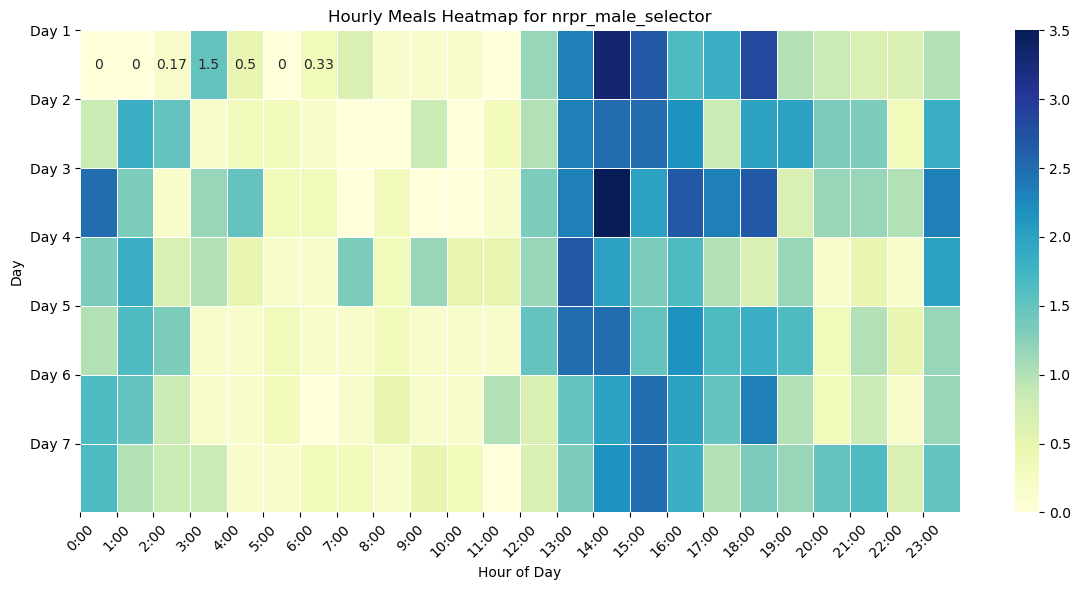

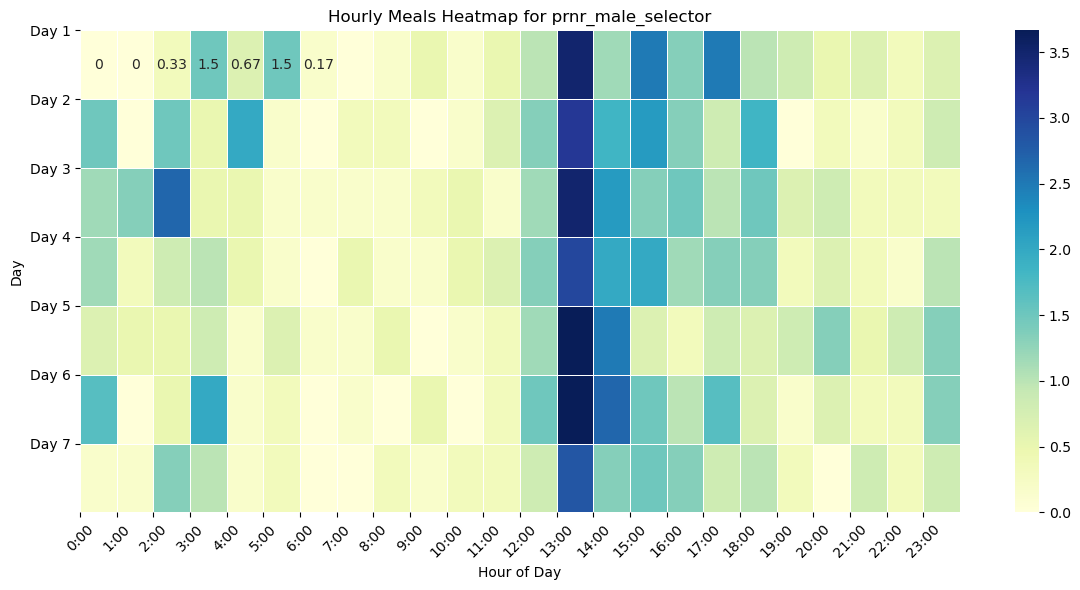

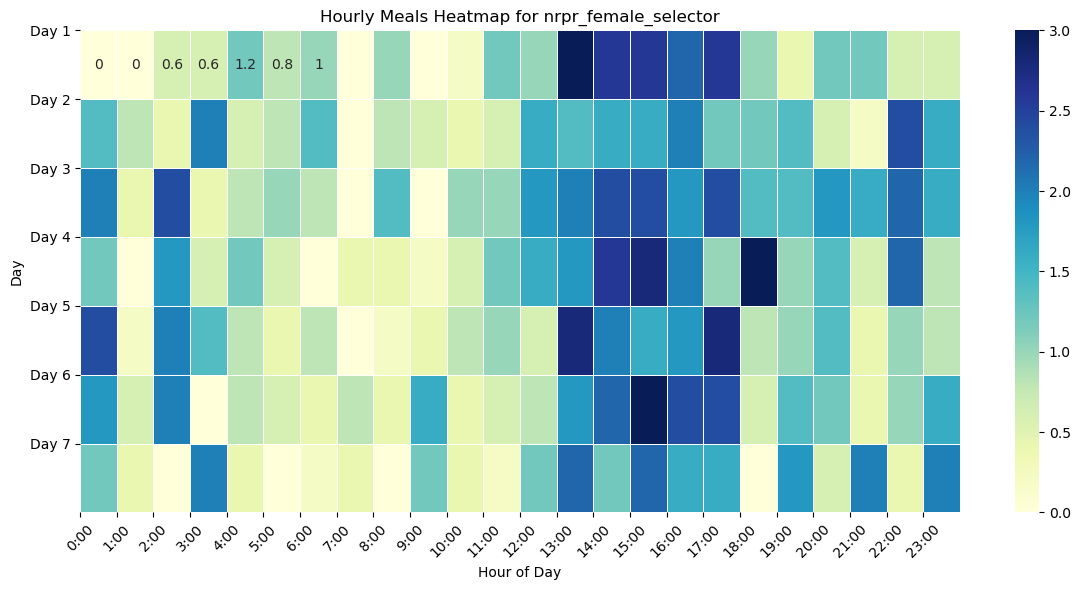

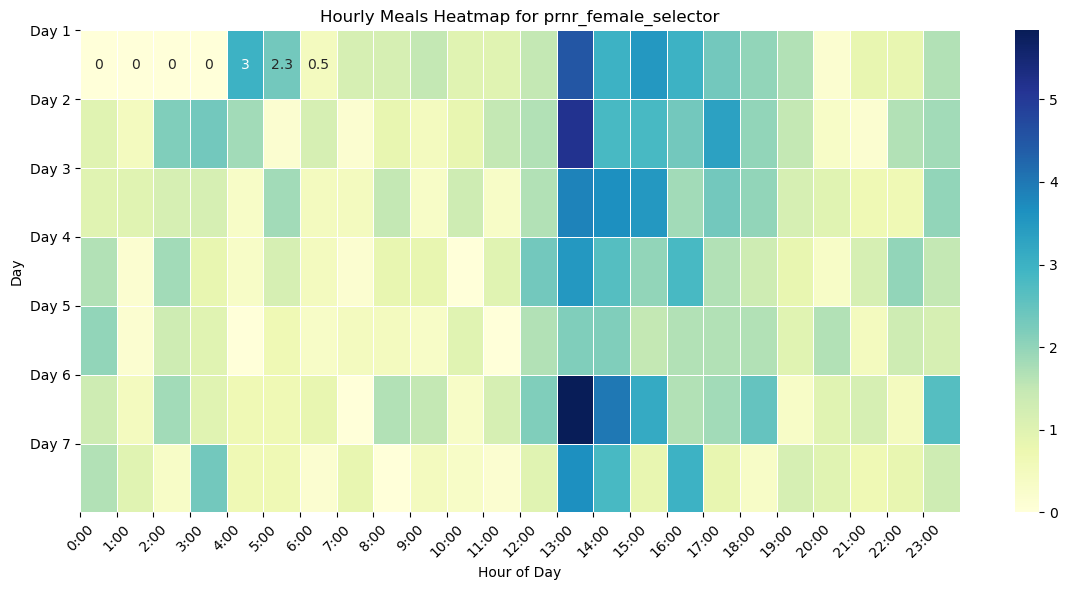

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get the hourly meals data for a specific selector
def get_hourly_meals_for_selector(mice, selector, phase="nr_hourly_meals"):
    selected_mice = [
        key for key in mice.keys() 
        if mice[key]["order"] == selector["order"] and mice[key]["sex"] == selector["sex"]
    ]

    if not selected_mice:
        print(f"No mice found for selector: {selector}")
        return np.zeros((7, 24))  # Return an empty heatmap if no mice are found

    # Initialize an array to accumulate hourly meal data for all selected mice
    aggregated_hourly_meals = np.zeros((7, 24))

    # Loop through selected mice and accumulate their hourly meal data
    for mouse_key in selected_mice:
        hourly_meals_per_day = np.array(mice[mouse_key][phase])
        aggregated_hourly_meals += hourly_meals_per_day

    # Calculate the average meals per hour if you want to normalize across mice
    aggregated_hourly_meals /= len(selected_mice)

    return aggregated_hourly_meals

# Define the selectors for different groups
selectors = {
    "nrpr_male_selector": {"order": 1, "sex": "M"},
    "prnr_male_selector": {"order": 2, "sex": "M"},
    "nrpr_female_selector": {"order": 1, "sex": "F"},
    "prnr_female_selector": {"order": 2, "sex": "F"}
}

# Visualize the heatmaps for each group
for selector_name, selector in selectors.items():
    # Get the aggregated hourly meals for the current group
    aggregated_hourly_meals = get_hourly_meals_for_selector(mice, selector, phase="nr_hourly_meals")

    # Create a heatmap using seaborn
    plt.figure(figsize=(12, 6))
    sns.heatmap(aggregated_hourly_meals, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5)

    # Set labels
    plt.title(f"Hourly Meals Heatmap for {selector_name}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day")

    # Customize tick labels to show hours and days more clearly
    plt.xticks(ticks=np.arange(24), labels=[f"{i}:00" for i in range(24)], rotation=45)
    plt.yticks(ticks=np.arange(7), labels=[f"Day {i+1}" for i in range(7)], rotation=0)

    # Show the plot
    plt.tight_layout()
    plt.show()


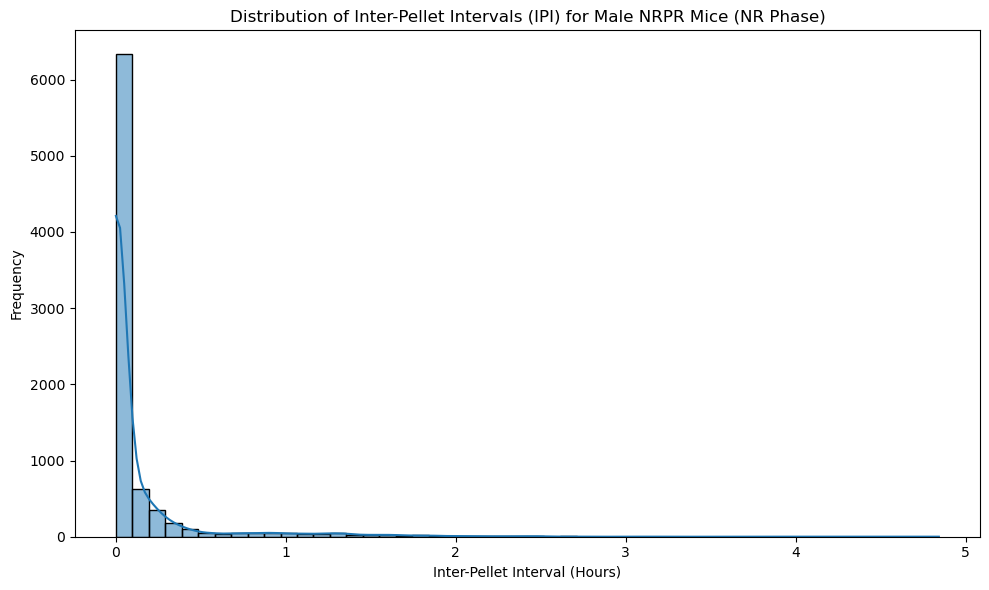

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get the IPIs for a specific selector in a specific phase
def get_ipi_for_selector(mice, selector, phase="nr_timestamps"):
    selected_mice = [
        key for key in mice.keys() 
        if mice[key]["order"] == selector["order"] and mice[key]["sex"] == selector["sex"]
    ]

    all_ipis = []

    if not selected_mice:
        print(f"No mice found for selector: {selector}")
        return []

    # Loop through the selected mice and accumulate their IPIs
    for mouse_key in selected_mice:
        timestamps = mice[mouse_key].get(phase, [])
        if timestamps:
            ipis = np.diff(np.array(timestamps))  # Calculate the IPIs
            all_ipis.extend(ipis)

    return np.array(all_ipis)

# Selector for nrpr male mice
nrpr_male_selector = {"order": 1, "sex": "M"}

# Get the IPIs for the male nrpr mice in the NR phase
ipi_data = get_ipi_for_selector(mice, nrpr_male_selector, phase="nr_timestamps")

# Plotting the distribution of IPIs
plt.figure(figsize=(10, 6))
sns.histplot(ipi_data, bins=50, kde=True)  # Use KDE (kernel density estimate) to smooth the histogram

# Set labels and title
plt.title("Distribution of Inter-Pellet Intervals (IPI) for Male NRPR Mice (NR Phase)")
plt.xlabel("Inter-Pellet Interval (Hours)")
plt.ylabel("Frequency")

# Show the plot
plt.tight_layout()
plt.show()


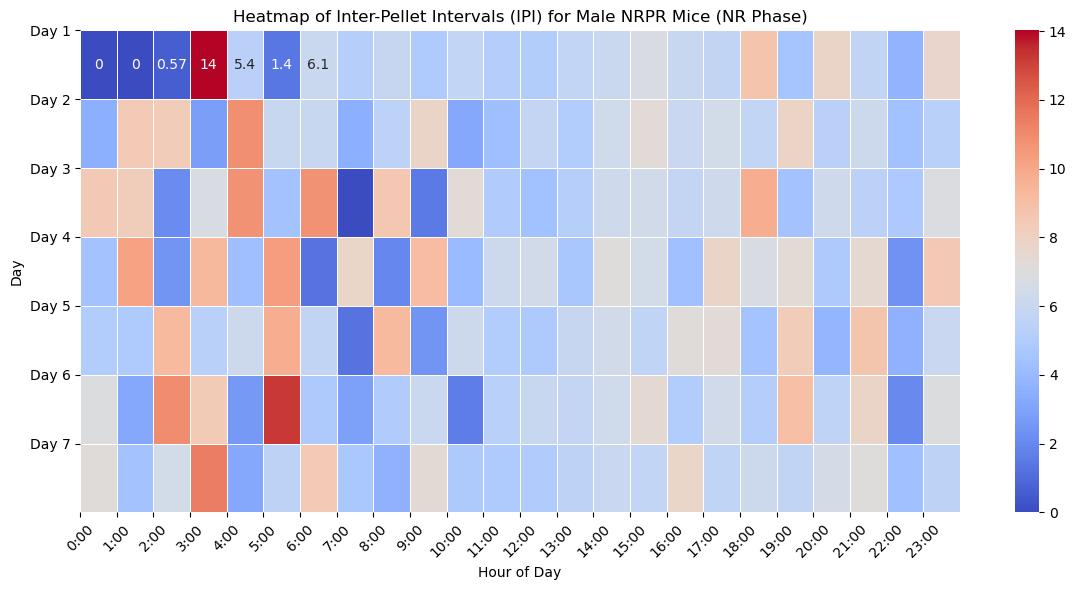

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to group IPIs into hourly bins across days
def get_ipi_heatmap_data(mice, selector, phase="nr_timestamps", days=7):
    selected_mice = [
        key for key in mice.keys() 
        if mice[key]["order"] == selector["order"] and mice[key]["sex"] == selector["sex"]
    ]

    if not selected_mice:
        print(f"No mice found for selector: {selector}")
        return np.zeros((days, 24))  # Return empty data if no mice are found

    # Initialize a 7x24 matrix to hold IPIs grouped by day and hour
    ipi_heatmap_data = np.zeros((days, 24))

    # Loop through selected mice and accumulate their IPIs
    for mouse_key in selected_mice:
        timestamps = mice[mouse_key].get(phase, [])
        if timestamps:
            ipis = np.diff(np.array(timestamps))  # Calculate the IPIs
            for i, ipi in enumerate(ipis):
                # Determine the hour and day for the IPI
                timestamp = timestamps[i]
                day = int(timestamp // 24)  # Determine the day
                hour = int(timestamp % 24)  # Determine the hour
                if day < days:  # Ensure we stay within the 7-day period
                    ipi_heatmap_data[day][hour] += ipi  # Accumulate IPI in the corresponding time bin

    # Average the IPIs by counting how many IPIs fell into each bin
    counts = np.zeros((days, 24))  # Track counts to avoid division by zero
    for i in range(days):
        for j in range(24):
            if ipi_heatmap_data[i][j] > 0:
                counts[i][j] = 1

    # Normalize by counts to get the average IPI in each time bin
    ipi_heatmap_data = np.divide(ipi_heatmap_data, counts, out=np.zeros_like(ipi_heatmap_data), where=counts != 0)

    return ipi_heatmap_data

# Selector for nrpr male mice
nrpr_male_selector = {"order": 1, "sex": "M"}

# Get the heatmap data for IPIs in the NR phase
ipi_heatmap_data = get_ipi_heatmap_data(mice, nrpr_male_selector, phase="nr_timestamps")

# Plotting the IPI heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(ipi_heatmap_data, annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)

# Set labels and title
plt.title("Heatmap of Inter-Pellet Intervals (IPI) for Male NRPR Mice (NR Phase)")
plt.xlabel("Hour of Day")
plt.ylabel("Day")

# Customize tick labels to show hours and days more clearly
plt.xticks(ticks=np.arange(24), labels=[f"{i}:00" for i in range(24)], rotation=45)
plt.yticks(ticks=np.arange(7), labels=[f"Day {i+1}" for i in range(7)], rotation=0)

# Show the plot
plt.tight_layout()
plt.show()
